In [6]:
import math
from types import SimpleNamespace
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms

import wandb

In [7]:
# Load the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:10<00:00, 16.4MB/s]


In [10]:
def get_dataloaders():
  return trainloader, testloader

In [13]:
INPUT_SIZE = 3 * 32 * 32
OUTPUT_SIZE = 10
HIDDEN_SIZE = 256
NUM_WORKERS = 2
CLASSES = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
DEVICE = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

def get_model(dropout):
    "Simple MLP with Dropout"
    return nn.Sequential(
        nn.Conv2d(3, 6, 5),   # (3, 32, 32) -> (6, 28, 28)
        nn.ReLU(),
        nn.MaxPool2d(2, 2),   # (6, 28, 28) -> (6, 14, 14)

        nn.Conv2d(6, 16, 5),  # (6, 14, 14) -> (16, 10, 10)
        nn.ReLU(),
        nn.MaxPool2d(2, 2),   # (16, 10, 10) -> (16, 5, 5)


        nn.Flatten(start_dim=1),  # Flatten to (batch_size, 16*5*5)

        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    ).to(DEVICE)

In [14]:
# Let's define a config object to store our hyperparameters
config = SimpleNamespace(
    epochs = 5,
    batch_size = 128,
    lr = 1e-5,
    dropout = 0.5,
    slice_size = 10_000,
    valid_pct = 0.2,
)

In [15]:
def validate_model(model, valid_dl, loss_func):
    "Compute the performance of the model on the validation dataset"
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.inference_mode():
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            val_loss += loss_func(outputs, labels) * labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)


In [16]:
def train_model(config):
    "Train a model with a given config"

    wandb.init(
        project="cifar10_cnn",
        config=config,
    )

    # Get the data
    train_dl, valid_dl = get_dataloaders()
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # A simple CNN model
    model = get_model(config.dropout)

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=config.lr)

    example_ct = 0

    for epoch in tqdm(range(config.epochs), total=config.epochs):
        model.train()

        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            example_ct += len(images)
            metrics = {
                "train/train_loss": train_loss,
                "train/epoch": epoch + 1,
                "train/example_ct": example_ct
            }
            wandb.log(metrics)

        # Compute validation metrics, log images on last epoch
        val_loss, accuracy = validate_model(model, valid_dl, loss_func)
        # Compute train and validation metrics
        val_metrics = {
            "val/val_loss": val_loss,
            "val/val_accuracy": accuracy
        }
        wandb.log(val_metrics)

    wandb.finish()

In [11]:
from google.colab import userdata
WANDB_API_KEY = userdata.get('WANDB_KEY')

In [ ]:
wandb.login(key=WANDB_API_KEY)

In [ ]:
train_model(config)

---

### WANDB Dashboard Results:

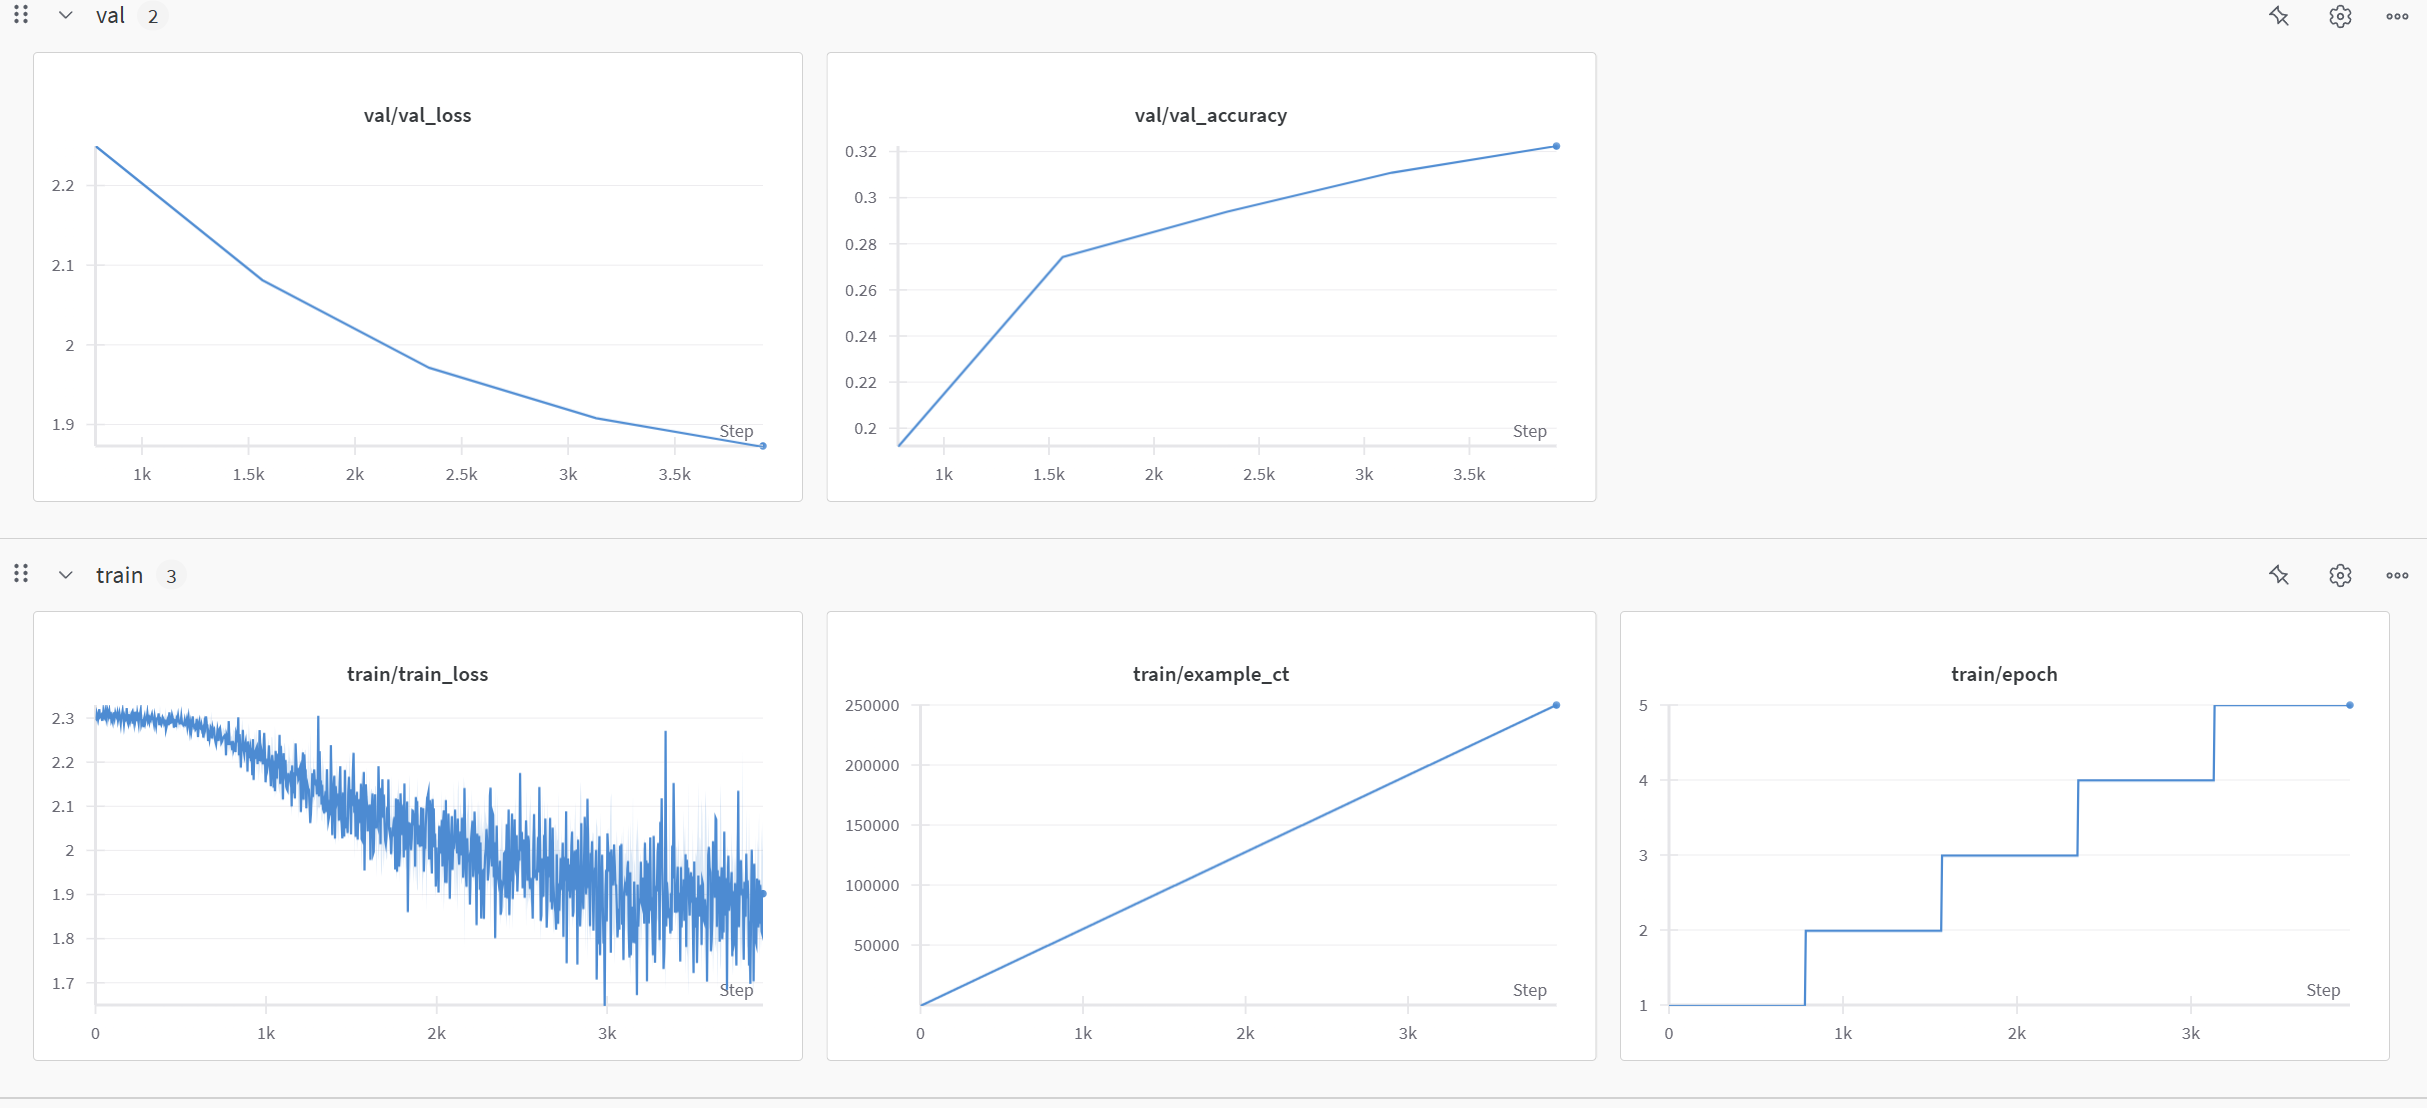